In [1]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_ckpt_path
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

from src.utils import *


In [3]:
plt.style.use('ggplot')

In [4]:
cmap = plt.get_cmap('viridis')

In [5]:
gpu = 3
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [34]:
load_pca = False

if load_pca:
    with open("pickle/trained_pca_on_dm_3D_norm_False.pkl", "rb") as file:
        pca_dict = pickle.load(file)   
else:
    pca_dict = {}

In [20]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Not reloading datamodule


# Useful functions

In [21]:

def plot_unorm_ssp_2D(unorm_test_truth_ssp_arr,
                      unorm_test_pca_ssp_arr,
                      unorm_test_ae_ssp_arr, 
                      dm,
                      bottleneck_shape_tuple,
                      t,
                      lat):
    
    
    depth_array = dm.depth_array
    coords = dm.coords
    
    unorm_test_truth_ssp_arr_2D = unorm_test_truth_ssp_arr[t,:,lat,:]
    unorm_test_ae_ssp_arr_2D = unorm_test_ae_ssp_arr[t,:,lat,:]
    unorm_test_pca_ssp_arr_2D = unorm_test_pca_ssp_arr[t,:,lat,:]
    
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(unorm_test_truth_ssp_arr_2D, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(unorm_test_pca_ssp_arr_2D, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(unorm_test_ae_ssp_arr_2D, cmap=cmap, aspect = "equal")
    
    

    ecs_truth_idx_2D = np.argmax(unorm_test_truth_ssp_arr_2D,axis=0)
    ecs_truth_2D = depth_array[ecs_truth_idx_2D]
    
    ecs_pca_idx_2D = np.argmax(unorm_test_pca_ssp_arr_2D,axis=0)
    ecs_pca_2D = depth_array[ecs_pca_idx_2D]
    
    ecs_ae_idx_2D = np.argmax(unorm_test_ae_ssp_arr_2D,axis=0)
    ecs_ae_2D = depth_array[ecs_ae_idx_2D]

    axs[0].plot(ecs_truth_idx_2D, label = "ECS")
    axs[1].plot(ecs_pca_idx_2D, label = f"ECS RMSE={np.sqrt(np.mean((ecs_truth_2D-ecs_pca_2D)**2)):.2f}m")
    axs[2].plot(ecs_ae_idx_2D, label = f"ECS RMSE ={np.sqrt(np.mean((ecs_truth_2D-ecs_ae_2D)**2)):.2f}m")
    
    


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    
    
    
    
    for ax in axs[:]:

        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        

    ae_bottleneck_shape,n_components = bottleneck_shape_tuple
    compression_rate_pca = len(depth_array)/n_components
    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\n{n_components} depth components, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_2D-unorm_test_pca_ssp_arr_2D)**2)):.8f}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_2D-unorm_test_ae_ssp_arr_2D)**2)):.8f}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Sound Speed reconstruction",x = 0.45, y = 0.80)
    
    


In [22]:
def plot_norm_ssp_2D(norm_test_truth_ssp_arr,
                     norm_test_ae_ssp_arr, 
                     dm,
                     ae_bottleneck_shape,
                     t,
                     lat):
    
    
    coords = dm.coords
    
    
    norm_test_truth_ssp_arr_2D = norm_test_truth_ssp_arr[t,:,lat,:]
    norm_test_ae_ssp_arr_2D = norm_test_ae_ssp_arr[t,:,lat,:]
    
    
    fig,axs = plt.subplots(1,2,figsize=(19,7), gridspec_kw={'width_ratios': [1, 1]})

    im1 = axs[0].imshow(norm_test_truth_ssp_arr_2D, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(norm_test_ae_ssp_arr_2D, cmap=cmap, aspect = "equal")
    
    

    # ecs_truth_idx_2D = np.argmax(norm_test_truth_ssp_arr_2D,axis=0)
    # ecs_truth_2D = depth_array[ecs_truth_idx_2D]
    
    # ecs_ae_idx_2D = np.argmax(norm_test_ae_ssp_arr_2D,axis=0)
    # ecs_ae_2D = depth_array[ecs_truth_idx_2D]

    # axs[0].plot(ecs_truth_idx_2D, label = "ECS")
    # axs[1].plot(ecs_ae_idx_2D, label = f"ECS RMSE ={np.sqrt(np.mean((ecs_truth_2D-ecs_ae_2D)**2)):.2f}m")
    
    


    y_tick_indices = np.linspace(0, len(coords["z"].data) - 1, 5, dtype=int)
    y_tick_values = coords["z"].data[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    
    
    
    
    for ax in axs[:]:
        
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")


    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((norm_test_truth_ssp_arr_2D-norm_test_ae_ssp_arr_2D)**2)):.8f}", fontsize = 10) #/np.sum(ssp_truth_norm_test_arr**2))*100

    axs[0].set_ylabel('z')


    cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("normalized")

    min_val, max_val = im2.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Normalized Sound Speed reconstruction",x = 0.45, y = 0.80)
    
    


In [23]:
def plot_imgs_depth_lon_filtered_2D(ssp_truth_unorm_test_arr,
                                    ssp_ae_unorm_test_arr,  
                                    ssp_3D_median,
                                    ecs_truth,
                                    ecs_pred_ae,
                                    ecs_pred_ae_median,
                                    depth_array,
                                    coords,
                                    compression_rate_ae, 
                                    bottleneck_shape,
                                    median_kernel):
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(ssp_truth_unorm_test_arr, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(ssp_ae_unorm_test_arr, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(ssp_3D_median, cmap=cmap, aspect = "equal")


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]
    

    indices_ecs_truth = np.searchsorted(depth_array, ecs_truth.detach().cpu().numpy())
    indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae.detach().cpu().numpy())
    indices_ecs_ae_median  = np.searchsorted(depth_array, ecs_pred_ae_median.flatten().detach().cpu().numpy())


    axs[0].plot(indices_ecs_truth, label = "ECS")
    axs[1].plot(indices_ecs_ae, label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae)**2)).item(),2)}m")
    axs[2].plot(indices_ecs_ae_median, label = f"ECS RMSE ={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae_median)**2)).item(),2)}m")


    for ax in axs[:]:
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        
        #ax.invert_yaxis() 

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\n \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_ae_unorm_test_arr)**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100
    axs[2].set_title(f"AE filtered reconstruction\n median filter kernel size: {median_kernel} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_3D_median)**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr**2))*100

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Sound Speed reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}",x = 0.45, y = 0.85)


In [24]:

def plot_unorm_ssp_profiles(unorm_test_truth_ssp_arr,
                            unorm_test_pca_ssp_arr,
                            unorm_test_ae_ssp_arr, 
                            dm,
                            bottleneck_shape_tuple,
                            t,
                            lat,
                            lon):
    
    
    depth_array = dm.depth_array
    

    
    unorm_test_truth_ssp_arr_profile = unorm_test_truth_ssp_arr[t,:,lat,lon]
    unorm_test_ae_ssp_arr_profile = unorm_test_ae_ssp_arr[t,:,lat,lon]
    unorm_test_pca_ssp_arr_profile = unorm_test_pca_ssp_arr[t,:,lat,lon]
    
    
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    axs[0].plot(unorm_test_truth_ssp_arr_profile, depth_array, c = "navy")  
    axs[1].plot(unorm_test_pca_ssp_arr_profile, depth_array, c="navy")
    axs[2].plot(unorm_test_ae_ssp_arr_profile, depth_array, c ="navy")


    ecs_truth_idx = np.argmax(unorm_test_truth_ssp_arr_profile,axis=0)
    ecs_truth = depth_array[ecs_truth_idx]
    
    ecs_pca_idx = np.argmax(unorm_test_pca_ssp_arr_profile,axis=0)
    ecs_pca = depth_array[ecs_pca_idx]
    
    ecs_ae_idx = np.argmax(unorm_test_ae_ssp_arr_profile,axis=0)
    ecs_ae = depth_array[ecs_ae_idx]


    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth)}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pca, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pca)}m", colors = "coral")

    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_ae, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_ae)}m", colors = "coral")




    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    ae_bottleneck_shape,n_components = bottleneck_shape_tuple
    compression_rate_pca = len(depth_array)/n_components
    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)
    
    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\n{n_components} depth components, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_profile-unorm_test_pca_ssp_arr_profile)**2)):.8f}m", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((unorm_test_truth_ssp_arr_profile-unorm_test_ae_ssp_arr_profile)**2)):.8f}m", fontsize = 10)



    axs[0].set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles reconstruction",x = 0.5, y = 1.05)
    
    

In [25]:

def plot_norm_ssp_profiles(norm_test_truth_ssp_arr,
                           norm_test_ae_ssp_arr, 
                           dm,
                           ae_bottleneck_shape,
                           t,
                           lat,
                           lon):
    
    
    coords = dm.coords
    z_array = coords["z"].data
    
    norm_test_truth_ssp_arr_profile = norm_test_truth_ssp_arr[t,:,lat,lon]
    norm_test_ae_ssp_arr_profile = norm_test_ae_ssp_arr[t,:,lat,lon]
    
    
    fig,axs = plt.subplots(1,2,figsize=(14,6), gridspec_kw={'width_ratios': [1,1]})

    axs[0].plot(norm_test_truth_ssp_arr_profile, z_array, c = "navy")  
    axs[1].plot(norm_test_ae_ssp_arr_profile, z_array, c ="navy")



    for ax in axs[:]:

        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    compression_rate_ae = np.prod(dm.test_shape)/np.prod(ae_bottleneck_shape)
    
    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\nbottleneck shape:{list(ae_bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.sqrt(np.mean((norm_test_truth_ssp_arr_profile-norm_test_ae_ssp_arr_profile)**2)):.8f}", fontsize = 10)



    axs[0].set_ylabel('z')


    fig.suptitle(f"Normalized Sound Speed Profiles reconstruction",x = 0.5, y = 1.05)
    
    

In [26]:
def plot_ssp_filtered_2D(ssp_truth_unorm_test_arr,ssp_ae_unorm_test_arr, 
                         ssp_3D_median,
                         ecs_truth, 
                         ecs_pred_ae, 
                         ecs_pred_ae_median,
                         depth_array,
                         lon,
                         compression_rate_ae, 
                         bottleneck_shape,
                         median_kernel):
        
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].plot(ssp_truth_unorm_test_arr[:,lon], depth_array, c = "navy")  
    im2 = axs[1].plot(ssp_ae_unorm_test_arr[:,lon], depth_array, c ="navy")
    im3 = axs[2].plot(ssp_3D_median[:,lon], depth_array, c="navy")



    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")
    

    
    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_pred_ae_median[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae_median[lon])}m", colors = "coral")




    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        


    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\n \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:,lon]-ssp_ae_unorm_test_arr[:,lon])**2)),8)}m", fontsize = 10)
    axs[2].set_title(f"AE filtered reconstruction\n median filter kernel size: {median_kernel} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:,lon]-ssp_3D_median[:,lon])**2)),8)}m", fontsize = 10)




    fig.suptitle(f"Sound Speed reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", y = 1.05)

In [27]:
def plot_ssp_above_depth_2D(ssp_truth_unorm_test_arr,
                            ssp_pca_unorm_test_arr,
                            ssp_ae_unorm_test_arr, 
                            ecs_truth, 
                            ecs_pred_pca, 
                            ecs_pred_ae, 
                            depth_array,
                            n_components,
                            lon, 
                            compression_rate_pca, 
                            compression_rate_ae, 
                            bottleneck_shape):
    
    depth_max = max(ecs_truth[lon],ecs_pred_ae[lon],ecs_pred_pca[lon]).item() 
    depth_max = np.ceil(depth_max + 0.5*depth_max)
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
    depth_idx = np.argmax(depth_array > depth_max)

    axs[0].plot(ssp_truth_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c = "navy")  
    axs[1].plot(ssp_pca_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c ="navy")   
    axs[2].plot(ssp_ae_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c="navy")


    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pred_pca[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_pca[lon])}m", colors = "coral")
    
    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")


    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\n{n_components} depth components, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_pca_unorm_test_arr[:depth_idx,lon])**2)),8)}m", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_ae_unorm_test_arr[:depth_idx,lon])**2)),8)}m", fontsize = 10)



    axs[0].set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles reconstruction in the first {int(depth_array[depth_idx])} m", fontsize = 15, y = 1.05)

In [28]:
def plot_ssp_filtered_above_depth_2D(ssp_truth_unorm_test_arr,
                                     ssp_ae_unorm_test_arr, 
                                     ssp_3D_median,
                                     ecs_truth, 
                                     ecs_pred_ae, 
                                     ecs_pred_ae_median,
                                     depth_array,
                                     lon,
                                     compression_rate_ae, 
                                     bottleneck_shape,
                                     median_kernel):
        

    depth_max = max(ecs_truth[lon],ecs_pred_ae[lon],ecs_pred_ae_median[lon]).item() 
    depth_max = np.ceil(depth_max + 0.5*depth_max)
    fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
    depth_idx = np.argmax(depth_array > depth_max)


    im1 = axs[0].plot(ssp_truth_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c = "navy")  
    im2 = axs[1].plot(ssp_ae_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c ="navy")
    im3 = axs[2].plot(ssp_3D_median[:depth_idx,lon], depth_array[:depth_idx], c="navy")



    xmin, xmax = axs[0].get_xlim()
    axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
    
    xmin, xmax = axs[1].get_xlim()
    axs[1].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")
    
    xmin, xmax = axs[2].get_xlim()
    axs[2].hlines(ecs_pred_ae_median[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae_median[lon])}m", colors = "coral")



    for ax in axs[:]:

        ax.legend(loc = "lower right")
        ax.set_xlabel("Sound Speed (°)")
        
        ax.invert_yaxis() 
        


    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"AE reconstruction\n \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_ae_unorm_test_arr[:depth_idx,lon])**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr[:depth_idx,lon]**2))*100
    axs[2].set_title(f"AE filtered reconstruction\n median filter kernel size: {median_kernel} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[:depth_idx,lon]-ssp_3D_median[:depth_idx,lon])**2)),8)}m", fontsize = 10) #/np.sum(ssp_truth_unorm_test_arr[:depth_idx,lon]**2))*100




    fig.suptitle(f"Sound Speed reconstruction in the first {int(depth_array[depth_idx])} m\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", y = 1.05)

In [29]:
def plot_ae_ssp_above_depth_2D(ssp_ae_unorm_test_arr,
                               ecs_pred_ae, 
                               depth_max,
                               depth_array,
                               lon,
                               compression_rate_ae, 
                               bottleneck_shape):
    
    
    fig,axs = plt.subplots(1,1,figsize=(8,6))
    depth_idx = np.argmax(depth_array > depth_max)

    axs.plot(ssp_ae_unorm_test_arr[:depth_idx,lon], depth_array[:depth_idx], c="navy")

    indices_ecs_ae_max = ssp_ae_unorm_test_arr[:,lon].argmax(axis=0)

    xmin, xmax = axs.get_xlim()
    axs.hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")

    axs.legend(loc = "lower right")
    axs.set_xlabel("Sound Speed (°)")

    axs.invert_yaxis() 
        

    axs.set_title(f"bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", fontsize = 10)


    axs.set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles AE reconstruction in the first {int(depth_array[depth_idx])}m",x = 0.5, y = 1)
        

In [30]:
def plot_ae_filtered_ssp_above_depth_2D(ssp_3D_median, 
                                        ecs_pred_ae_median,depth_max,
                                        depth_array,
                                        lon,
                                        compression_rate_ae, 
                                        bottleneck_shape,median_kernel):
    
    
    fig,axs = plt.subplots(1,1,figsize=(8,6))
    depth_idx = np.argmax(depth_array > depth_max)

    axs.plot(ssp_3D_median[:depth_idx,lon], depth_array[:depth_idx], c="navy")

    indices_ecs_ae_max = ssp_3D_median[:,lon].argmax(axis=0)

    xmin, xmax = axs.get_xlim()
    axs.hlines(ecs_pred_ae_median[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae_median[lon])}m", colors = "coral")

    axs.legend(loc = "lower right")
    axs.set_xlabel("Sound Speed (°)")

    axs.invert_yaxis() 
        

    axs.set_title(f"bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)}", fontsize = 10)


    axs.set_ylabel('Depth (m)')


    fig.suptitle(f"Sound Speed Profiles AE reconstruction in the first {int(depth_array[depth_idx])}m\n  median filter kernel size: {median_kernel}",x = 0.5, y = 1)
        

# Plot model

In [31]:
ckpt_dict = {
             "AE_on_all_loss_1":"outputs/remote/AE_CNN_3D/dev_rapport_2024/test_on_loss_weights/pred_10_grad_1000000_max_pos_0.01_max_value_100_fft_0.1_weighted_100_inflection_pos_0.01_inflection_value_100/depth_pre_treatment_none_n_components_107/pooling_Max_on_dim_all/channels_[1, 8, 8, 8]",
             "AE_on_all_loss_2":"outputs/remote/AE_CNN_3D/dev_rapport_2024/test_on_loss_weights/pred_0.5_grad_10000_max_pos_0.01_max_value_0.05_fft_0.0_weighted_1_inflection_pos_0.01_inflection_value_0.05/depth_pre_treatment_none_n_components_107/pooling_Max_on_dim_all/channels_[1, 8, 8, 8, 8]",

}

In [41]:
unorm_test_truth_ssp_arr.mean()

1517.2025

Model: AE_on_all_loss_1 



  0%|          | 0/1 [00:00<?, ?it/s]

Fitting PCA


/homes/o23gauvr/Documents/thèse/code/FASCINATION/src/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lit_mod.load_state_dict(torch.load(model_ckpt_path, map_locat

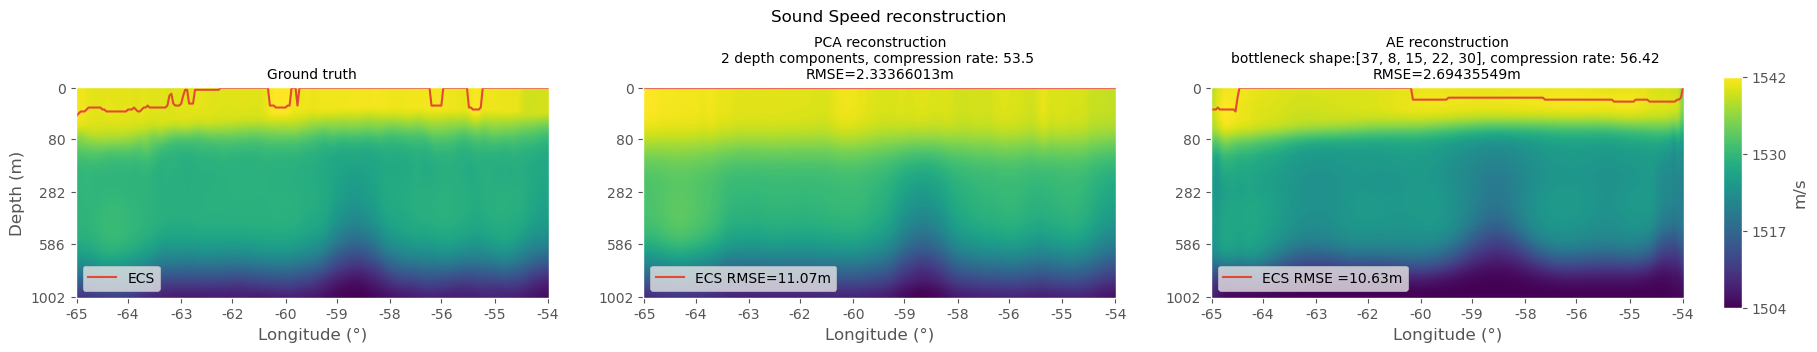

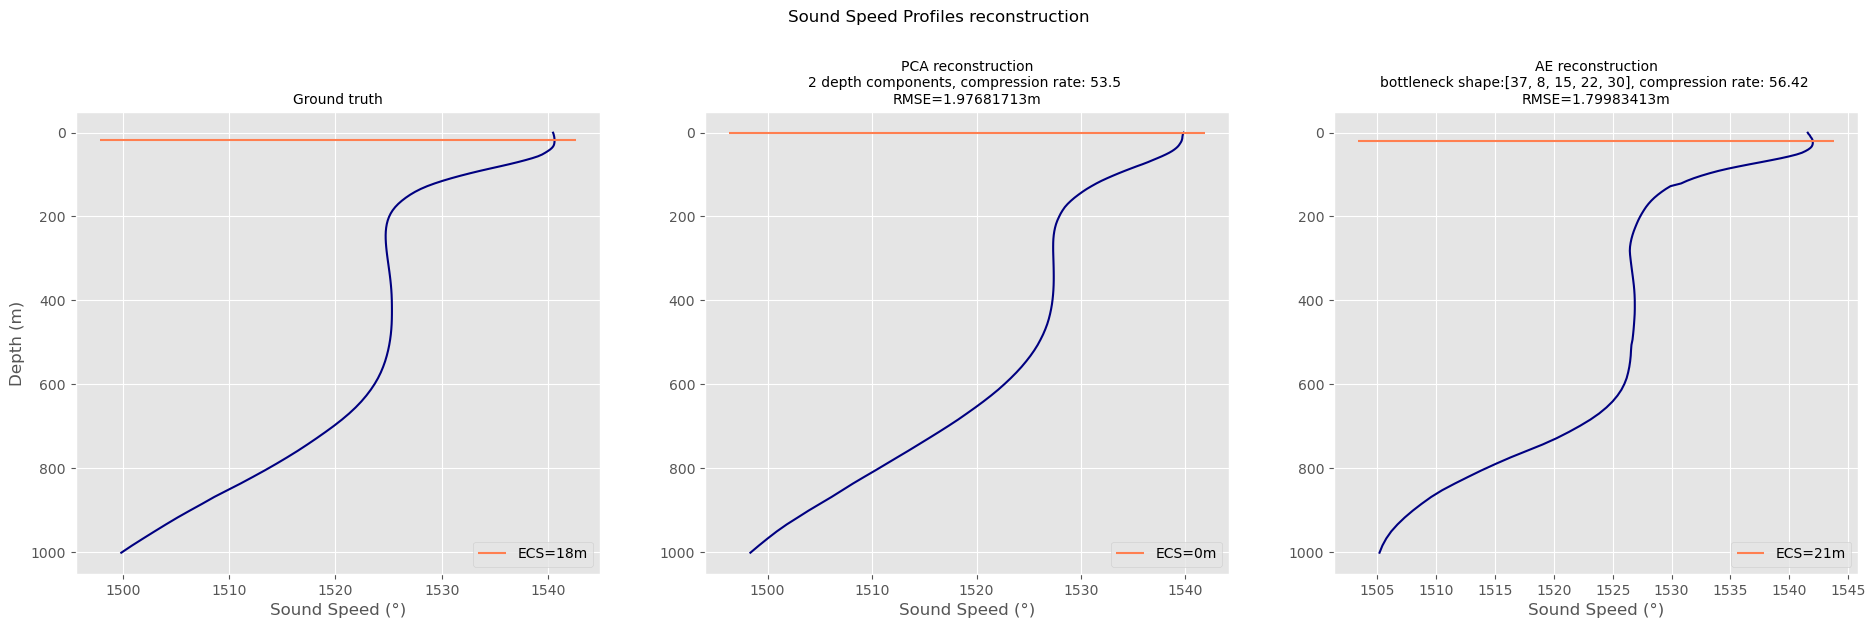

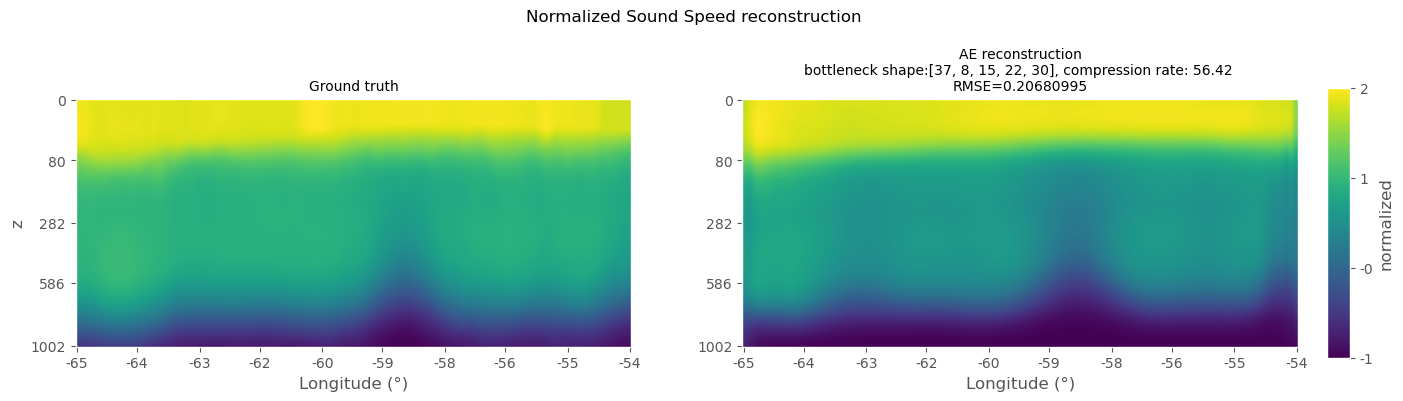

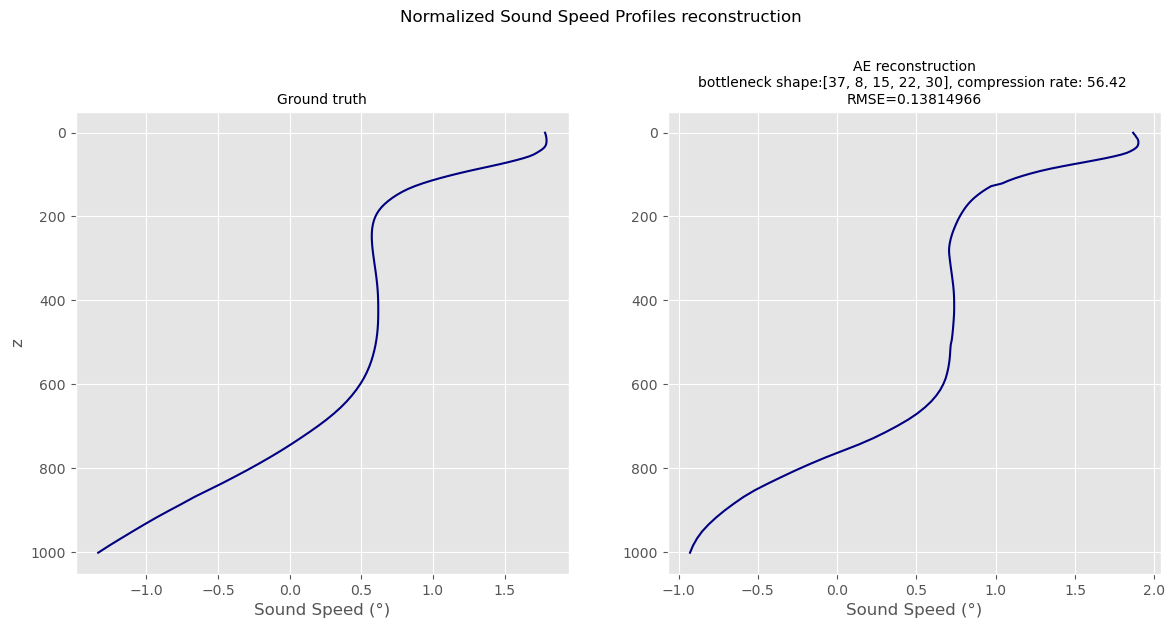

100%|██████████| 1/1 [00:14<00:00, 14.19s/it]


Model: AE_on_all_loss_2 



  0%|          | 0/1 [00:00<?, ?it/s]

Fitting PCA


/homes/o23gauvr/Documents/thèse/code/FASCINATION/src/utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lit_mod.load_state_dict(torch.load(model_ckpt_path, map_locat

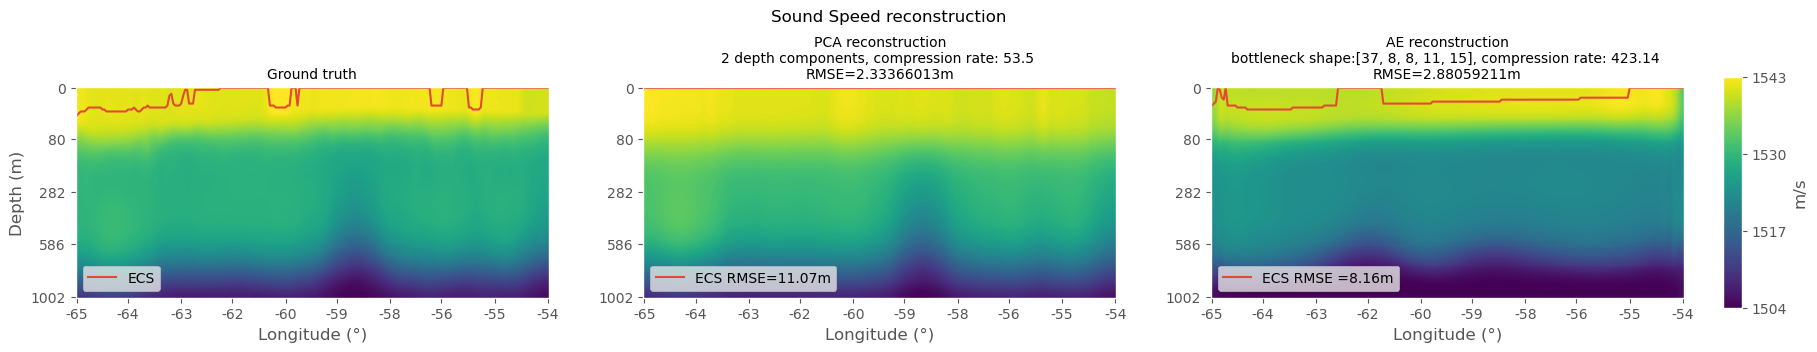

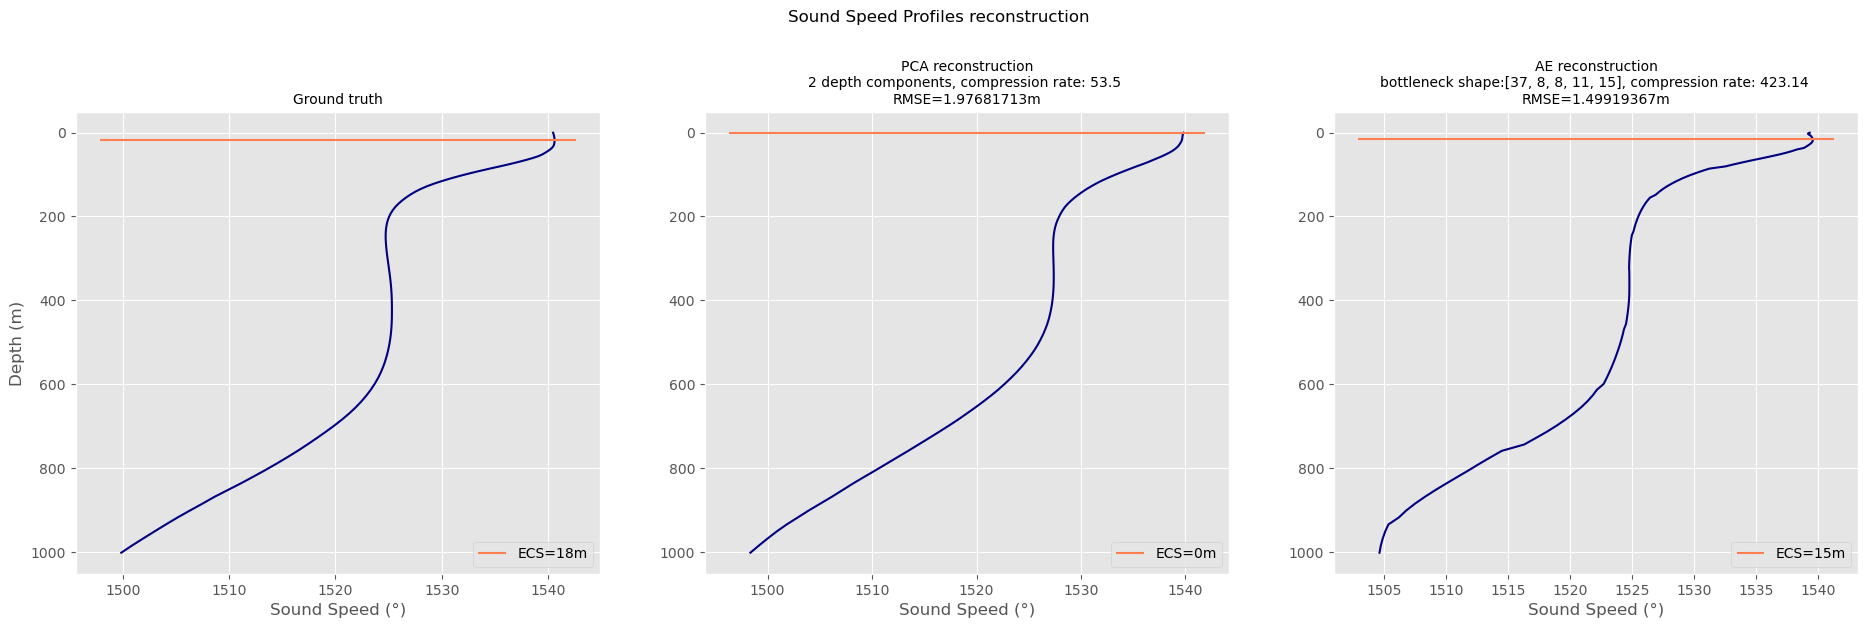

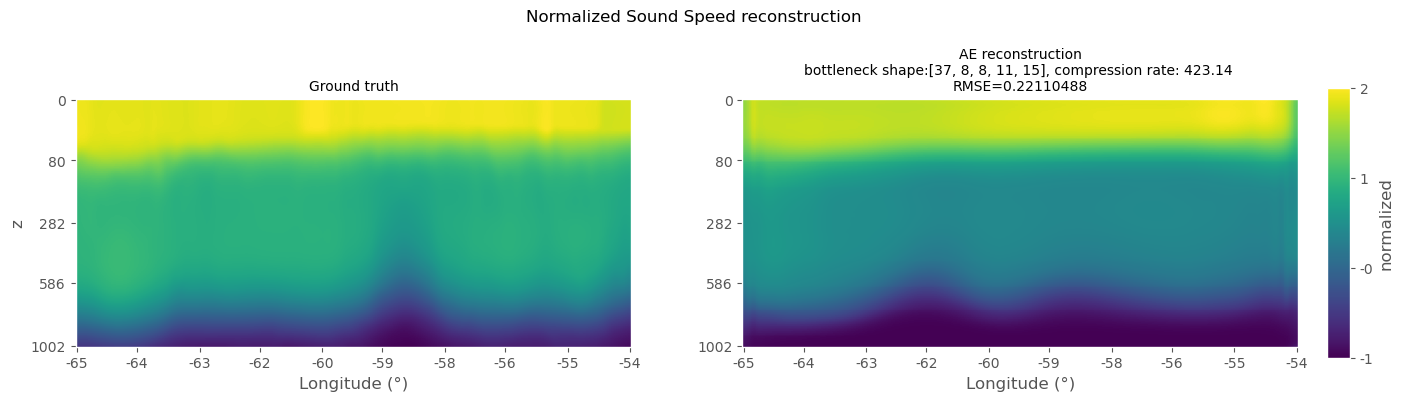

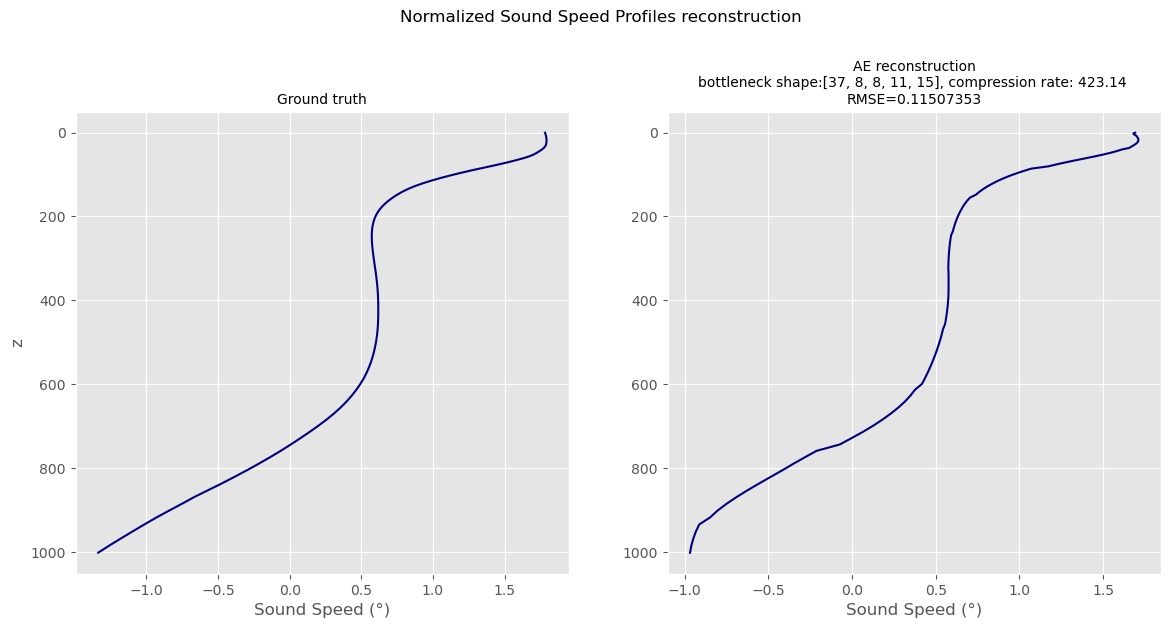

100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


In [43]:
t,lat = 10,10
lon = 10


for model_name in ckpt_dict.keys():

    print(f"Model: {model_name} \n")

    ckpt_list = list(Path(ckpt_dict[model_name]).rglob('*.ckpt'))

    for ckpt_path in tqdm(ckpt_list):
        
        ckpt_path = str(ckpt_path)

        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        

        except:
            print(f"Can't load config")
            continue
        
        
    
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="test")
            test_ssp_truth_tens = torch.tensor(test_truth_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)

            
            if not load_pca:
                print("Fitting PCA")
                train_truth_ssp_arr,  dm = loading_datamodule_phase(dm,phase="fit")

        
        else:

            print("Inititing datamodule; Generating train and test datasets")
            
            dm = hydra.utils.call(cfg.datamodule)  
            test_truth_ssp_arr, dm = loading_datamodule_phase(dm,phase="test")
            test_ssp_truth_tens = torch.tensor(test_truth_ssp_arr, dtype=getattr(torch,cfg.dtype), device=device)
            dm_dict[cfg.datamodule] = dm

            if not load_pca:
                print("Fitting PCA")
                train_truth_ssp_arr, _, dm = loading_datamodule_phase(dm,device,phase="fit")
            

        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    
        except:
            print("Can't load model ")
            continue

        test_ae_ssp_arr = lit_model(test_ssp_truth_tens).detach().cpu().numpy()
        ae_bottleneck_shape = lit_model.model_AE.bottleneck_shape
        
        
        unorm_test_truth_ssp_arr = unorm_ssp_arr_3D(test_truth_ssp_arr,dm)
        unorm_test_ae_ssp_arr = unorm_ssp_arr_3D(test_ae_ssp_arr,dm)
        
        unorm_ssp_shape = unorm_test_truth_ssp_arr.shape

        
        n_components = min(ae_bottleneck_shape[2],unorm_ssp_shape[1])
        n_components = 2


        if load_pca:
            pca = pca_dict[n_components]
        
        else:
            pca = PCA(n_components = n_components)
            pca.fit(train_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,train_truth_ssp_arr.shape[1]))

        unorm_test_pca_ssp_arr = unorm_ssp_arr_3D(pca.inverse_transform(pca.transform(test_truth_ssp_arr.transpose(0,2,3,1).reshape(-1,unorm_ssp_shape[1]))).reshape(unorm_ssp_shape[0],unorm_ssp_shape[2],unorm_ssp_shape[3],unorm_ssp_shape[1]).transpose(0,3,1,2),dm)
        
            
        
        bottleneck_shape_tuple = (ae_bottleneck_shape,n_components)

        plot_unorm_ssp_2D(unorm_test_truth_ssp_arr,
                        unorm_test_pca_ssp_arr,
                        unorm_test_ae_ssp_arr, 
                        dm,
                        bottleneck_shape_tuple,
                        t,
                        lat)


        plot_unorm_ssp_profiles(unorm_test_truth_ssp_arr,
                                unorm_test_pca_ssp_arr,
                                unorm_test_ae_ssp_arr, 
                                dm,
                                bottleneck_shape_tuple,
                                t,
                                lat,
                                lon)

        plot_norm_ssp_2D(test_truth_ssp_arr,
                        test_ae_ssp_arr, 
                        dm,
                        ae_bottleneck_shape,
                        t,
                        lat)


        plot_norm_ssp_profiles(test_truth_ssp_arr,
                            test_ae_ssp_arr, 
                            dm,
                            ae_bottleneck_shape,
                            t,
                            lat,
                            lon)
        
        plt.show()


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 